In [316]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

In [317]:
df = pd.read_csv("data/cancer/breast-cancer.csv", index_col="id")

In [318]:
df = df.drop(columns='Unnamed: 32')

In [319]:
df.shape

(569, 31)

# Exploratory Data Analysis

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

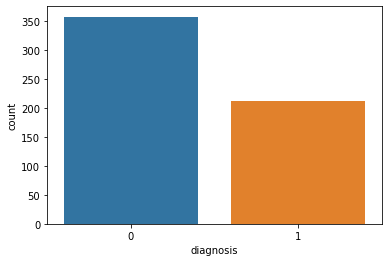

In [320]:
diagnosis_map = {'B':0, 'M':1}
df['diagnosis'] = df['diagnosis'].map(diagnosis_map)

sns.countplot(x=df['diagnosis'])

# Import sklearn

In [321]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [322]:
sklearn.__version__

'0.23.2'

# Split data

In [323]:
x = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [324]:
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [325]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [326]:
print(f"train set size: {x_train.shape}")
print(f"test set size: {x_test.shape}")

train set size: (455, 30)
test set size: (114, 30)


# Scale

In [327]:
scaler = StandardScaler()

In [328]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)

In [329]:
print(np.min(x_train_sc))
print(np.max(x_train_sc))

-3.176344188780568
11.731855390439586


In [330]:
mm_scaler = MinMaxScaler()

In [331]:
x_train_mm = mm_scaler.fit_transform(x_train)
x_test_mm = mm_scaler.fit_transform(x_test)

In [332]:
print(np.min(x_train_mm))
print(np.max(x_train_mm))

0.0
1.0


# 1) Run Clustering

In [333]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [334]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(x_train_sc)
    sum_of_squared_distances.append(km.inertia_)

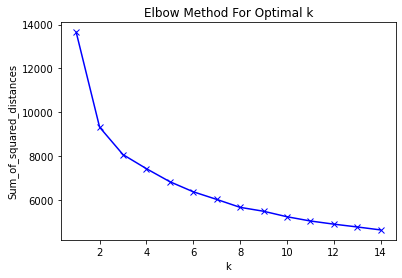

In [335]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 1.1) K-Means

In [336]:
# Silhouette Score: This is a better measure to decide the number of clusters to be formulated from the data. 
# It is calculated for each instance and the formula goes like this:
# Silhouette Coefficient = (x-y)/ max(x,y)

# consider two measures:
#   The mean distance between a sample and all other points in the same cluster.
#   The mean distance between a sample and all other points in the next nearest cluster.
# i.e. it checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

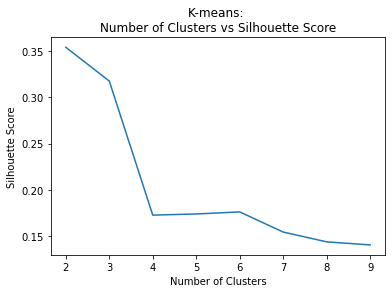

In [337]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_train_sc)
    labels = km.predict(x_train_sc)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    data.append([n, sil])

kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"])
plt.show()


## 1.2) EM

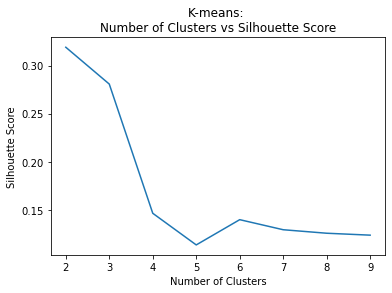

In [338]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_train_sc)
    labels = gmm.predict(x_train_sc)
    sil = silhouette_score(x_train_sc, labels, metric='euclidean')
    
    data.append([n, sil])

em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(em_df["Clusters"], em_df["Silhouette Score"])
plt.show()

In [339]:
### BIC
# Bayesian information criterion (BIC)
# how much is good the GMM in terms of predicting the data we actually have. 
# The lower is the BIC, the better is the model to actually predict the data we have

# 2) Dimensionality reduction

In [340]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn import random_projection as RP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## 2.1) PCA

In [341]:
retain_variance = 0.90

pca = PCA(retain_variance)
principalComponents = pca.fit(x_train_sc)

comp_num = pca.n_components_

print(f"{comp_num} components picked to retain {retain_variance} variance")

7 components picked to retain 0.9 variance


In [342]:
pca = PCA(n_components=comp_num)
principalComponents = pca.fit_transform(x_train_sc)

In [343]:
columns = []
for i in range(comp_num):
    columns.append(f"principal component {i+1}")
    
print(columns)

['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7']


In [344]:
principalDf = pd.DataFrame(data = principalComponents, columns = columns)

In [345]:
principalDf['diagnosis'] = y_train.values

In [346]:
principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,diagnosis
0,-3.039161,1.106670,0.408520,0.651555,-1.441651,-0.144347,-0.239526,0
1,-2.282314,0.400452,0.263275,1.701245,-0.466131,0.602709,-0.252815,0
2,-1.084095,-1.995444,-1.193536,-1.491333,0.565976,0.192945,-0.540865,0
3,-2.561100,0.179338,1.085279,-0.621311,-0.474188,-0.176897,-0.257803,0
4,-2.848305,-1.017616,-0.847290,1.762525,-0.021795,0.302202,0.756510,0


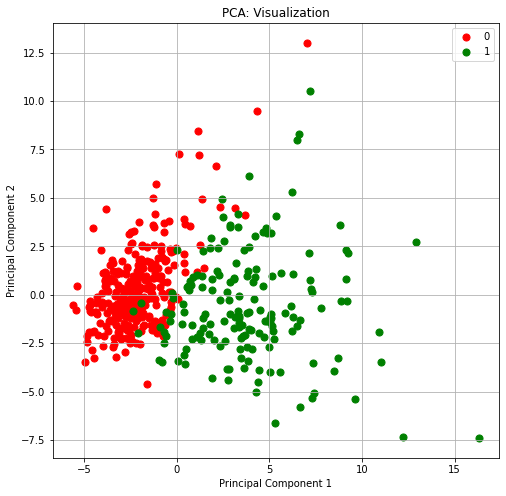

In [347]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA: Visualization')

diagnosis = [0, 1]
colors = ['r', 'g']

for target, color in zip(diagnosis, colors):
    indicesToKeep = principalDf['diagnosis'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

    ax.legend(diagnosis)
ax.grid()

In [348]:
# The explained variance tells you how much information (variance) can be 
# attributed to each of the principal components

In [349]:
print("Explained variation per principal component:\n")
print(pca.explained_variance_ratio_)

Explained variation per principal component:

[0.43430767 0.19740115 0.09351771 0.06677661 0.05642452 0.04071619
 0.02149254]


In [350]:
np.sum(pca.explained_variance_ratio_)

0.9106363829667495

In [351]:
def run_pca(x_train):
    """
    Run PCA and plot variance retained for each number of components
    """
    
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1): 
        pca = PCA(n_components=num)
        principalComponents = pca.fit_transform(x_train)
        
        variance_retained = np.sum(pca.explained_variance_ratio_)
        
        data.append([num, variance_retained])
        
    df = pd.DataFrame(data, columns=["Features", "Variance Retained"])
    
    plt.title("PCA: \nNumber of Features vs Variance Retained")
    plt.xlabel("Number of Features")
    plt.ylabel("Variance Retained") 
    plt.plot(df["Features"], df["Variance Retained"])
    plt.show()

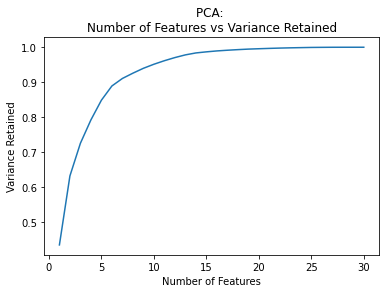

In [352]:
run_pca(x_train_sc)

In [353]:
# 7 features to retain 90% of the variance

## 2.2) ICA

In [370]:
def run_ica(x_train):
    """
    Run ICA from n_components 1 to N and get average  kurtosis
    """
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1):    
        transformer = ICA(n_components=num, random_state=0)
        x_transformed = transformer.fit_transform(x_train)

        x_transformed = pd.DataFrame(x_transformed)
        kurtosis = x_transformed.kurtosis(axis=0)
        kurtosis_mean = kurtosis.abs().mean()
        
        data.append(kurtosis_mean)
        print(kurtosis_mean)
        

    plt.xlabel("Number of IC")
    plt.ylabel("Kurtosis")
    plt.plot(range(1, n+1), data)
    plt.grid()
    plt.show()

0.9966876299638496
3.38971263606171
5.397555748388009
5.401016494221768
7.952751876041543
7.275453730832422
10.560719628115752
10.305302280283012
13.095294178474616
14.12128703132199
20.422930504877925
20.204610236923674
19.741100380349717
20.306768406158312
21.137835362199162
21.30758136072306
24.34513663189163
25.287521905370774
24.390798340352557
25.364672531155296
27.930731024627015
28.359025163969058
30.682527596381203
32.47656732927501
32.30254128295453
33.415777864777425
32.34801127241007
32.4638727833893
34.08769197737268
33.66436022828681


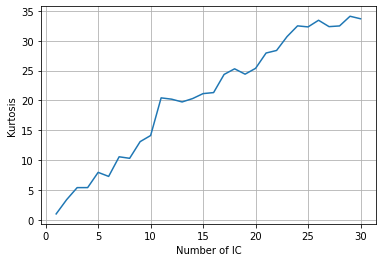

In [371]:
run_ica(x_train_sc)

In [356]:
def run_ica_2(x_train):
    """
    Run ICA for N n_components kurtosis for each component
    """
    n = x_train_sc.shape[1]  
    transformer = ICA(n_components=n, random_state=0)
    x_transformed = transformer.fit_transform(x_train)
    x_transformed = pd.DataFrame(x_transformed)    
    kurtosis = x_transformed.kurtosis(axis=0)
    print(kurtosis)
    kurtosis_abs = kurtosis.abs()
        
    data = []
    for i, k in enumerate(kurtosis_abs):
        data.append([f"IC{i+1}", k])
    
    p = pd.DataFrame(data, columns=["IC", "Kurtosis"])
    
    # get only top 10 IC    
    p.sort_values(by="Kurtosis", ascending=False, inplace=True)
    
    x_labels = p["IC"][:10]
    y_values = p["Kurtosis"][:10]    
    
#     plt.title(title)
    plt.ylabel("Kurtosis") 
    plt.bar(x_labels, y_values)
    plt.show()
    


0       9.952886
1       4.758882
2      51.423999
3      17.055521
4       3.435681
5     203.697309
6       2.782612
7     249.004256
8       1.687786
9      13.291123
10     29.248202
11     -0.560857
12      3.975138
13      6.115748
14      9.853228
15     35.474407
16      2.622418
17      7.075782
18     18.851063
19      4.323989
20      5.178269
21     45.372366
22      7.509873
23      6.872511
24     97.942676
25      5.071784
26     90.103064
27     39.334446
28     18.355744
29     18.999188
dtype: float64


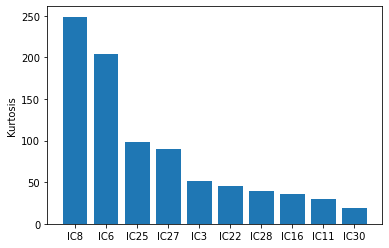

In [357]:
run_ica_2(x_train_sc)

## 2.3 RCA  (Randomized Projection)

In [358]:
from sklearn.metrics import mean_squared_error as MSE

In [359]:
def run_rp(x_train):
    """
    random projection
    """

    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1):
#         transformer = RP.SparseRandomProjection(n_components=num, random_state=0)
        
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=0)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data.append([num, error])
        
        print(f"{num} error={error}")
        
    df = pd.DataFrame(data, columns=["Features", "Reconstruction Error (MSE)"])
      
    plt.title("Random Projection: \nNumber of Features vs Reconstruction Error")
    plt.xlabel("Number of Features")
    plt.ylabel("Reconstruction Error (MSE)") 
    plt.plot(df["Features"], df["Reconstruction Error (MSE)"])
    plt.show()

1 error=0.9591388869980736
2 error=0.9402563262606025
3 error=0.8997627582750789
4 error=0.7804784445097371
5 error=0.7720018025369867
6 error=0.7398317399772064
7 error=0.6837749139819014
8 error=0.6643771233479747
9 error=0.638833114930472
10 error=0.5965833065858527
11 error=0.5713166734123777
12 error=0.5386771986395035
13 error=0.47834198302005343
14 error=0.4286268960595964
15 error=0.40464821208114027
16 error=0.3855461633381738
17 error=0.36928747357999114
18 error=0.32229227103860636
19 error=0.30987486361945327
20 error=0.2602769995951951
21 error=0.24103065783634556
22 error=0.23176286141676572
23 error=0.218649436904855
24 error=0.1490881012782022
25 error=0.12866219075200863
26 error=0.10561464873869184
27 error=0.059350765649550684
28 error=0.02745783743869112
29 error=0.013707656458000919
30 error=1.3705112033626296e-29


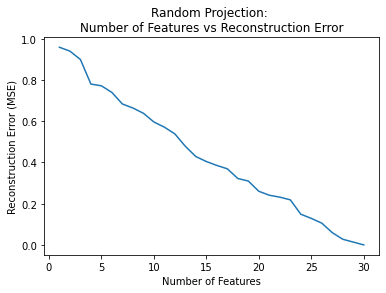

In [360]:
run_rp(x_train_sc)

## 2.4 LDA (Linear Discriminant Analysis)

In [395]:
def run_lda(x_train, y_train):
    """
    Linear Discriminant Analysis
    """

    # n_components cannot be larger than min(n_features, n_classes - 1).
    
    n_features = x_train_sc.shape[1]
    n_classes = len(np.unique(y_train))
    n = np.min([n_features, n_classes - 1])
    
    data = []
    
    for num in range(1, n+1):
        clf = LDA(n_components=num)
        x_transformed = clf.fit_transform(x_train, y_train)


In [396]:
run_lda(x_train_sc, y_train)

# 3) DR -> Clustering

- 3.1) PCA -> K-means
- 3.2) PCA -> EM

- 3.3) ICA -> K-means
- 3.4) ICA -> EM

- 3.5) RP -> K-means
- 3.6) RP -> EM

- 3.7) LDA -> K-means
- 3.8) LDA -> EM

## 3.1) PCA -> K-means

In [376]:
pca = PCA(n_components = 7)
x_transformed = pca.fit_transform(x_train_sc)

x_transformed = pd.DataFrame(x_transformed)

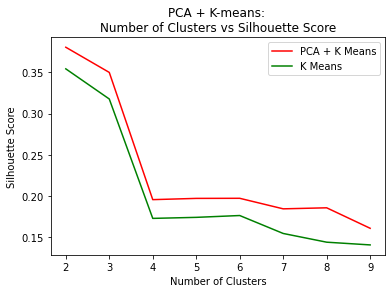

In [377]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("PCA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_kmeans_df["Clusters"], pca_kmeans_df["Silhouette Score"], color='r', label='PCA + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.2) PCA -> EM

In [378]:
pca = PCA(n_components = 7)
x_transformed = pca.fit_transform(x_train_sc)

x_transformed = pd.DataFrame(x_transformed)

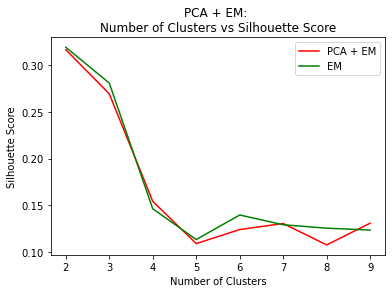

In [379]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("PCA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='PCA + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

## 3.3) ICA -> K-means

In [385]:
transformer = ICA(n_components=29, random_state=0)
x_transformed = transformer.fit_transform(x_train_sc)

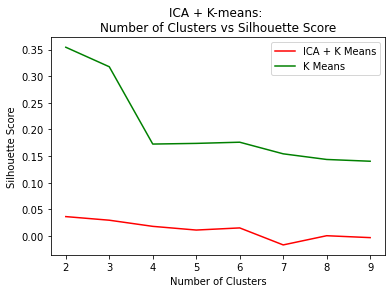

In [386]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

ica_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("ICA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_df["Clusters"], ica_kmeans_df["Silhouette Score"], color='r', label='ICA + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.4) ICA -> EM

In [387]:
transformer = ICA(n_components=29, random_state=0)
x_transformed = transformer.fit_transform(x_train_sc)

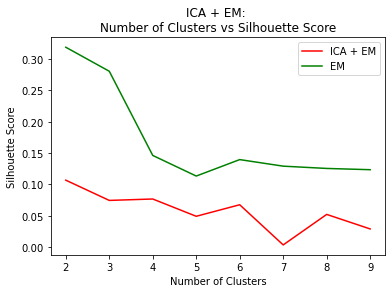

In [388]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("ICA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='ICA + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

In [ ]:
`

## 3.5) RP -> K-means

In [389]:
transformer = RP.GaussianRandomProjection(n_components=5, random_state=0)
x_transformed = transformer.fit_transform(x_train_sc)

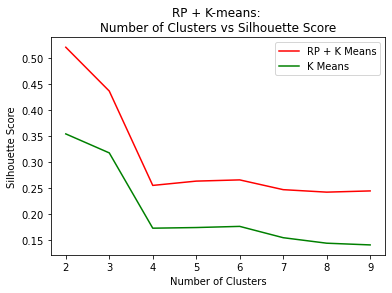

In [390]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

ica_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("RP + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_df["Clusters"], ica_kmeans_df["Silhouette Score"], color='r', label='RP + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## 3.6) RP -> EM

In [393]:
transformer = RP.GaussianRandomProjection(n_components=5, random_state=0)
x_transformed = transformer.fit_transform(x_train_sc)

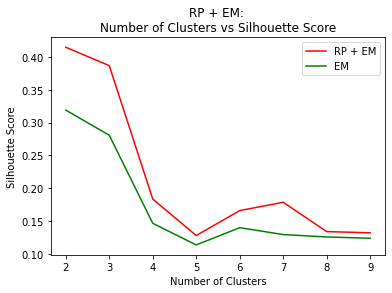

In [394]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("RP + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='RP + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()

## LDA -> K-means

In [397]:
clf = LDA(n_components=1)
x_transformed = clf.fit_transform(x_train_sc, y_train)

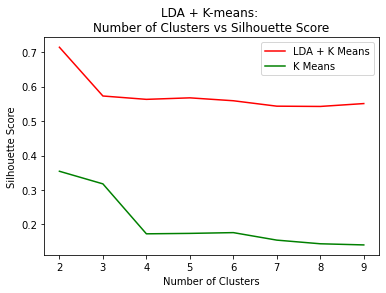

In [398]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    km = KMeans(n, random_state=0)
    km = km.fit(x_transformed)
    labels = km.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

ica_kmeans_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("LDA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_df["Clusters"], ica_kmeans_df["Silhouette Score"], color='r', label='LDA + K Means')
plt.plot(kmeans_df["Clusters"], kmeans_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.show()

## LDA -> EM

In [400]:
clf = LDA(n_components=1)
x_transformed = clf.fit_transform(x_train_sc, y_train)

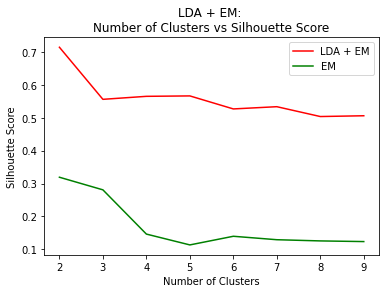

In [401]:
n_clusters=np.arange(2, 10)
data=[]

for n in n_clusters:
    gmm = GaussianMixture(n, random_state=0)
    gmm = gmm.fit(x_transformed)
    labels = gmm.predict(x_transformed)
    sil = silhouette_score(x_transformed, labels, metric='euclidean')
    
    data.append([n, sil])

pca_em_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])

plt.title("LDA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_df["Clusters"], pca_em_df["Silhouette Score"], color='r', label='LDA + EM')
plt.plot(em_df["Clusters"], em_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.show()